In [1]:
# prepare data for lstm
import pandas as pd
from pandas import DataFrame
from pandas import read_csv
from numpy import array
from numpy import sqrt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import SpatialDropout1D
import matplotlib.pyplot as plt

In [2]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix - 1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# load dataset
dataset = read_csv('/content/drive/My Drive/weather_dataset.csv', header=0, index_col=0)
mean_value_dewptm = dataset['dewptm'].mean()
dataset['dewptm'].fillna(value=mean_value_dewptm, inplace=True)
mean_value_hum = dataset['hum'].mean()
dataset['hum'].fillna(value=mean_value_hum, inplace=True)
mean_value_pressurem = dataset['pressurem'].mean()
dataset['pressurem'].fillna(value=mean_value_pressurem, inplace=True)
mean_value_wdrid = dataset['wdrid'].mean()
dataset['wdrid'].fillna(value=mean_value_wdrid, inplace=True)
mean_value_wspdm = dataset['wspdm'].mean()
dataset['wspdm'].fillna(value=mean_value_wspdm, inplace=True)

In [5]:
values = dataset.values

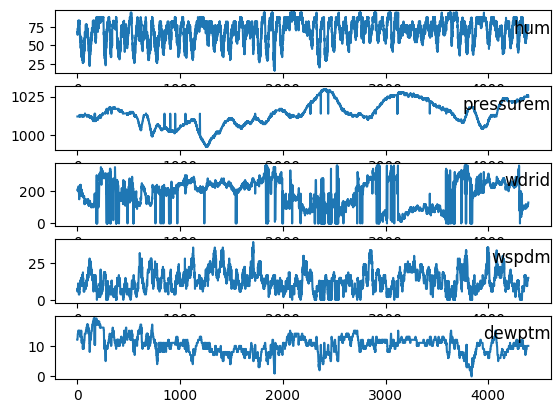

In [6]:
# specify columns to plot
groups = [0, 1, 2, 3, 4]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [7]:
# ensure all data is float
values = values.astype('float32')

In [8]:
# choose a number of time steps
n_steps = 1

In [9]:
# convert into input/output
X, y = split_sequences(values, n_steps)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [10]:
# reshape the data
n_features = X.shape[2]
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1] * n_features))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1] * n_features))

In [11]:
...
# design network
model = Sequential()
model.add(LSTM(200, input_shape=(n_steps * n_features, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(200))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [12]:
# fit network
history = model.fit(x_train, y_train, epochs=500, batch_size=100, validation_data=(x_test, y_test), verbose=2)

Epoch 1/500
36/36 - 13s - loss: 20.9373 - val_loss: 8.0928 - 13s/epoch - 372ms/step
Epoch 2/500
36/36 - 0s - loss: 8.0425 - val_loss: 7.7187 - 225ms/epoch - 6ms/step
Epoch 3/500
36/36 - 0s - loss: 7.6967 - val_loss: 7.2680 - 214ms/epoch - 6ms/step
Epoch 4/500
36/36 - 0s - loss: 6.9663 - val_loss: 6.5075 - 230ms/epoch - 6ms/step
Epoch 5/500
36/36 - 0s - loss: 6.5262 - val_loss: 6.2693 - 269ms/epoch - 7ms/step
Epoch 6/500
36/36 - 0s - loss: 6.2202 - val_loss: 6.0412 - 221ms/epoch - 6ms/step
Epoch 7/500
36/36 - 0s - loss: 6.1025 - val_loss: 5.8540 - 310ms/epoch - 9ms/step
Epoch 8/500
36/36 - 0s - loss: 6.0619 - val_loss: 5.8181 - 309ms/epoch - 9ms/step
Epoch 9/500
36/36 - 0s - loss: 5.8421 - val_loss: 5.9810 - 329ms/epoch - 9ms/step
Epoch 10/500
36/36 - 0s - loss: 5.7843 - val_loss: 5.5346 - 344ms/epoch - 10ms/step
Epoch 11/500
36/36 - 0s - loss: 5.6814 - val_loss: 5.5867 - 327ms/epoch - 9ms/step
Epoch 12/500
36/36 - 0s - loss: 5.6988 - val_loss: 5.5658 - 330ms/epoch - 9ms/step
Epoch 13/5

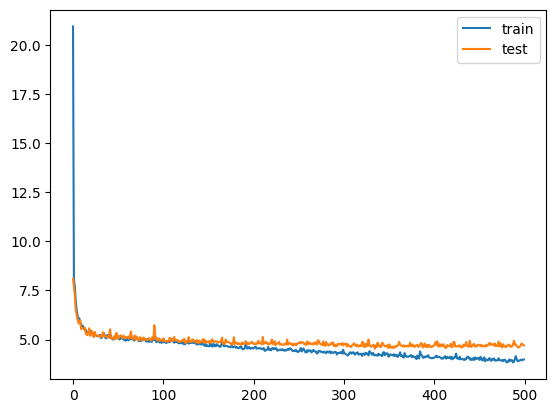

In [13]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [14]:
y_pred = model.predict(x_test)
y_pred = y_pred.reshape(y_pred.shape[0])

28/28 [==============================] - 1s 3ms/step


In [15]:
print("RMSE on Test Data = ", sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("MAE on Test Data = ", metrics.mean_absolute_error(y_test, y_pred))
print("R2 on Test Data = ", metrics.r2_score(y_test, y_pred))

RMSE on Test Data =  2.169162
MAE on Test Data =  1.5981576
R2 on Test Data =  0.4071468466324307


In [16]:
df1 = DataFrame({'Actual': y_test, 'Predicted': y_pred, 'variance': y_test - y_pred})
df1.head()

,Actual,Predicted,variance
0,10.0,9.524120,0.475880
1,12.0,9.903725,2.096275
2,11.0,9.970625,1.029375
3,11.0,11.390524,-0.390524
4,6.0,9.737148,-3.737148


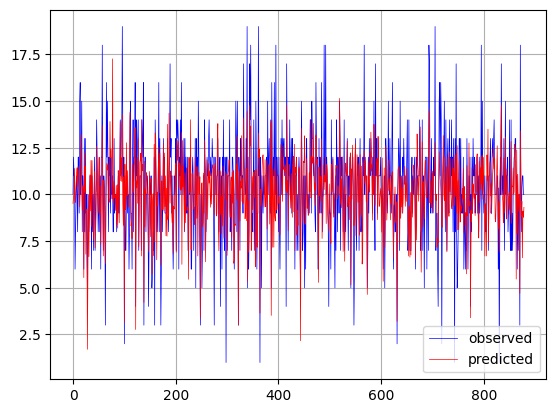

In [17]:
x_ax = range(len(x_test))
plt.plot(x_ax, y_test, lw=0.5, color='blue', label='observed')
plt.plot(x_ax, y_pred, lw=0.5, color='red', label='predicted')
plt.legend(loc='best')
plt.grid()
